In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Question_Pairs_BiLSTM

Mounted at /content/drive
/content/drive/MyDrive/Question_Pairs_BiLSTM


In [2]:
import pandas as pd
import numpy as np

In [3]:
data_train = pd.read_csv('data/train_dataset.csv')
data_val = pd.read_csv('data/val_dataset.csv')

### BertWordPiece Tokenizer

In [4]:
!pip install -q transformers

     |████████████████████████████████| 2.0MB 7.5MB/s 
     |████████████████████████████████| 3.2MB 56.0MB/s 
     |████████████████████████████████| 890kB 54.8MB/s 


In [5]:
from tokenizers import BertWordPieceTokenizer
import os

In [6]:
f = open('data/questions.raw', 'w', encoding='utf-8')
for i in data_train.question1.to_list() + data_train.question2.to_list():
    f.write(i)
    f.write('\n')
f.close()

In [7]:
tokenizer = BertWordPieceTokenizer(lowercase=True)

In [8]:
tokenizer.train('data/questions.raw')

In [9]:
tokenizer.save_model('data/')

['data/vocab.txt']

In [10]:
tokenizer = BertWordPieceTokenizer('data/vocab.txt')

In [11]:
# test
print('tokens: {}'.format(tokenizer.encode("I'am Hungry!!!").tokens))
print('ids: {}'.format(tokenizer.encode("I'am Hungry!!!").ids))

tokens: ['[CLS]', 'i', "'", 'am', 'hungry', '!', '!', '!', '[SEP]']
ids: [2, 51, 11, 1561, 9183, 5, 5, 5, 3]


### Data Preprocessing

In [12]:
from torch.utils import data
import torch
from torch.nn.utils.rnn import pad_sequence

In [13]:
class CustomDataset(data.Dataset):
    def __init__(self, docs_1, docs_2, labels, tokenizer):
        self.docs_1 = docs_1
        self.docs_2 = docs_2
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.docs_1)

    def __getitem__(self, item):
        docs_1 = str(self.docs_1[item])
        docs_2 = str(self.docs_2[item])
        labels = int(self.labels[item])
        encoded_docs_1 = self.tokenizer.encode(docs_1)
        encoded_docs_2 = self.tokenizer.encode(docs_2)
        return dict(
            input_ids_1 = torch.tensor(encoded_docs_1.ids),
            input_ids_2 = torch.tensor(encoded_docs_2.ids),
            labels = labels
            )

In [14]:
train_data = CustomDataset(
    data_train.question1.to_numpy(),
    data_train.question2.to_numpy(), 
    data_train.is_duplicate.to_numpy(),
    tokenizer
    )
validation_data = CustomDataset(
    data_val.question1.to_numpy(),
    data_val.question2.to_numpy(), 
    data_val.is_duplicate.to_numpy(),
    tokenizer
    )

In [15]:
def padding(batch):
    q1 = [q1['input_ids_1'] for q1 in batch]
    q2 = [q2['input_ids_2'] for q2 in batch]
    t = [t['labels'] for t in batch]
    len_q1 = [len(q1['input_ids_1']) for q1 in batch]
    len_q2 = [len(q2['input_ids_2']) for q2 in batch]
    q1_pad = pad_sequence(q1, batch_first=True, padding_value=0)
    q2_pad = pad_sequence(q2, batch_first=True, padding_value=0)
    return q1_pad, q2_pad, torch.tensor(t), torch.tensor(len_q1), torch.tensor(len_q2)

In [16]:
train_loader = data.DataLoader(train_data, batch_size = 64, shuffle=True, collate_fn=padding)
validation_loader = data.DataLoader(validation_data, batch_size = 128, collate_fn=padding)

In [17]:
for q1_pad, q2_pad, t, len_q1, len_q2 in train_loader:
    print('questions_1: {}, shape: {}'.format(q1_pad, q1_pad.shape))
    print('')
    print('len_questions_1: {}, shape: {}'.format(len_q1, len_q1.shape))
    print('')
    print('questions_2: {}, shape: {}'.format(q2_pad, q2_pad.shape))
    print('')
    print('len_questions_2: {}, shape: {}'.format(len_q2, len_q2.shape))
    print('')
    print('lables: {}, shape: {}'.format(t, t.shape))
    break

questions_1: tensor([[   2, 1396, 2686,  ...,    0,    0,    0],
        [   2, 1391, 1396,  ...,    0,    0,    0],
        [   2, 2018, 2597,  ...,    0,    0,    0],
        ...,
        [   2, 1546, 1623,  ...,    0,    0,    0],
        [   2, 1435, 1396,  ...,    0,    0,    0],
        [   2, 1391, 1396,  ...,    0,    0,    0]]), shape: torch.Size([64, 40])

len_questions_1: tensor([18,  8, 21, 16, 16, 12, 40, 12,  9, 12, 17, 12, 17, 15, 16, 12,  8, 24,
        25, 10, 22,  8,  8, 13, 12, 22, 17, 14, 21, 14, 19, 13, 21,  8, 28, 16,
        31, 24, 23, 19, 10,  7, 16, 12, 16, 12, 17, 12, 18, 11,  8, 13, 17, 14,
        11, 13, 13, 20,  8, 12, 22,  7,  9, 11]), shape: torch.Size([64])

questions_2: tensor([[    2,  1396, 21353,  ...,     0,     0,     0],
        [    2,  1411, 24654,  ...,     0,     0,     0],
        [    2,  1391,  2756,  ...,     0,     0,     0],
        ...,
        [    2,  1546,    11,  ...,     0,     0,     0],
        [    2,  8503,  1879,  ...,     0

In [18]:
for q1_pad, q2_pad, t, len_q1, len_q2 in validation_loader:
    print('questions_1: {}, shape: {}'.format(q1_pad, q1_pad.shape))
    print('')
    print('len_questions_1: {}, shape: {}'.format(len_q1, len_q1.shape))
    print('')
    print('questions_2: {}, shape: {}'.format(q2_pad, q2_pad.shape))
    print('')
    print('len_questions_2: {}, shape: {}'.format(len_q2, len_q2.shape))
    print('')
    print('lables: {}, shape: {}'.format(t, t.shape))
    break

questions_1: tensor([[    2,  1403,  1398,  ...,     0,     0,     0],
        [    2,  1541,    43,  ...,     0,     0,     0],
        [    2,  1396, 19829,  ...,     0,     0,     0],
        ...,
        [    2,  1486,  1754,  ...,     0,     0,     0],
        [    2,  1391,  1396,  ...,     0,     0,     0],
        [    2,  1391,    11,  ...,     0,     0,     0]]), shape: torch.Size([128, 46])

len_questions_1: tensor([11, 10, 11, 16, 10, 24, 22, 11, 11, 13, 20, 31, 16,  9, 31, 10, 21, 46,
        12, 11, 15, 11, 26,  9,  9, 10, 18, 11, 14, 14, 28, 12, 14, 11,  9, 10,
        15, 19, 16, 12, 18, 11, 11, 14, 12, 25, 16, 14, 13, 10, 15, 15, 17, 11,
        17, 11, 12, 10, 28, 14, 13,  9, 15, 16, 13, 20, 14, 11, 10, 10, 19, 16,
        11, 20, 14, 18,  7, 12,  7, 20, 12, 12,  9, 11, 17, 18, 22, 11, 12, 17,
        19, 22, 11, 18, 20,  9, 11, 13, 12, 12, 13, 17, 11, 11, 30,  8, 11, 11,
        10, 14, 15, 16, 12, 12, 11, 22, 12, 11, 23, 10, 10, 13, 22, 34, 13, 15,
        19, 18]),

### Bidirectional LSTM

In [19]:
import torch.nn as nn
device = "cuda:0" if torch.cuda.is_available() else "cpu"
!nvidia-smi

Fri Mar 26 04:22:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
class BiLSTM(nn.Module):
  def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes):
    super(BiLSTM, self).__init__()
    self.v = n_vocabs
    self.e = embed_dims
    self.u = n_lstm_units
    self.l = n_lstm_layers
    self.o = n_output_classes
    self.padd_idx = tokenizer.get_vocab()['[PAD]']
    self.embed = nn.Embedding(
        self.v,
        self.e,
        self.padd_idx
        )
    self.bilstm = nn.LSTM(
        self.e,
        self.u,
        self.l,
        batch_first = True,
        bidirectional = True,
        dropout = 0.5
        )
    self.linear = nn.Linear(
        self.u * 4,
        self.o
        )  
  
  def forward(self, X):
    # initial_hidden
    h0 = torch.zeros(self.l * 2, X[0].size(0), self.u).to(device)
    c0 = torch.zeros(self.l * 2, X[0].size(0), self.u).to(device)
    
    # embedding
    out1 = self.embed(X[0].to(device))
    out2 = self.embed(X[1].to(device))

    # pack_padded_sequence
    out1 = nn.utils.rnn.pack_padded_sequence(out1, X[3].cpu(), batch_first=True, enforce_sorted=False)
    out2 = nn.utils.rnn.pack_padded_sequence(out2, X[4].cpu(), batch_first=True, enforce_sorted=False)
    
    # NxTxh, lxNxh
    out1, _ = self.bilstm(out1, (h0, c0))
    out2, _ = self.bilstm(out2, (h0, c0))
    
    # pad_packed_sequence
    out1, _ = nn.utils.rnn.pad_packed_sequence(out1, batch_first=True)
    out2, _ = nn.utils.rnn.pad_packed_sequence(out2, batch_first=True)

    # take only the final time step
    out1 = out1[range(out1.shape[0]), X[3] - 1, :]
    out2 = out2[range(out2.shape[0]), X[4] - 1, :]
    
    # concatenate out1&2
    out = torch.cat((out1, out2), 1)
    
    # linear layer
    out = self.linear(out)

    iout = torch.max(out, 1)[1]
    return iout, out

In [21]:
train_labels = torch.cat([i[2] for i in train_loader])
negative = (train_labels == 0.).sum(dim=0).item()
positive = (train_labels == 1.).sum(dim=0).item()

In [22]:
print(f'number data in training set {len(train_data)}')
print(f'number of negative data in training set {negative}')
print(f'number of positive data in training set {positive}')

number data in training set 323429
number of negative data in training set 203998
number of positive data in training set 119431


class_weight :

n = 203998 * (119431 / (119431 + 203998)) = 75329.3153613312

p = 119431 * (203998 / (119431 + 203998)) = 75329.3153613312

In [23]:
torch.manual_seed(42)
model = BiLSTM(tokenizer.get_vocab_size(), 512, 512, 2, 2).to(device)
class_weight = torch.tensor([positive/(positive+negative), negative/(positive+negative)]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight, reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [24]:
print(model)

BiLSTM(
  (embed): Embedding(30000, 512, padding_idx=0)
  (bilstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)


In [25]:
import sys
from tqdm import tqdm
from datetime import datetime

num_epochs = 5
losses = []
accuracies  = []
val_losses = []
val_accuracies = []
val_loss_min = np.inf

for epoch in range(num_epochs):
    print('------------------------------------------------------------------------------------------')
    print('epoch: {}/{}:'.format(epoch + 1, num_epochs))   
    print('------------------------------------------------------------------------------------------')
    t0 = datetime.now()

    train_tqdm_bar = tqdm(enumerate(train_loader), total = (len(train_loader)), leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    val_tqdm_bar = tqdm(enumerate(validation_loader), total = (len(validation_loader)),  leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for idx, X in train_tqdm_bar:
        labels = X[2].to(device)
        iout, out = model(X)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
        optimizer.step()
        running_loss += loss
        running_corrects += torch.sum(iout == labels)
        train_tqdm_bar.set_description(desc = 'train'.format(epoch + 1, num_epochs))
        batch_idx = (idx + 1) * 64

        train_tqdm_bar.set_postfix(
            loss = running_loss.item() / batch_idx if idx + 1 < len(train_loader) else running_loss.item() / len(train_loader.dataset)
            ,acc = running_corrects.item() / batch_idx if idx + 1 < len(train_loader) else running_corrects.item() / len(train_loader.dataset)
            )
    
    model.eval()
    with torch.no_grad():
        for val_idx, v_X in val_tqdm_bar:
            v_labels = v_X[2].to(device)
            v_iout, v_out = model(v_X)
            v_loss = criterion(v_out, v_labels)
            val_running_loss += v_loss
            val_running_corrects += torch.sum(v_iout == v_labels)
            val_tqdm_bar.set_description('validate'.format(epoch + 1, num_epochs))
            val_batch_idx = (val_idx + 1) * 128

            val_tqdm_bar.set_postfix(
                val_loss = val_running_loss.item() / val_batch_idx if val_idx + 1 < len(validation_loader) else val_running_loss.item() / len(validation_loader.dataset)
                ,val_acc = val_running_corrects.item() / val_batch_idx if val_idx + 1 < len(validation_loader) else val_running_corrects.item() / len(validation_loader.dataset)
                )
    
    epoch_loss = running_loss/len(train_loader.dataset)
    losses.append(epoch_loss)
    epoch_accuracy = running_corrects/len(train_loader.dataset)
    accuracies.append(epoch_accuracy)
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_accuracy = val_running_corrects/len(validation_loader.dataset)
    val_accuracies.append(val_epoch_accuracy)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
            }
    
    print('training loss: {:.4f}, acc: {:.2f}'.format(epoch_loss, epoch_accuracy))
    print('validation loss: {:.4f}, acc: {:.2f}'.format(val_epoch_loss, val_epoch_accuracy))
    print('elapsed time: {}'.format(str(datetime.now() - t0).split('.')[0]))

    if val_epoch_loss <= val_loss_min:
      print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
      torch.save(checkpoint, 'checkpoint/ex2/question_pairs_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
      val_loss_min = val_epoch_loss

------------------------------------------------------------------------------------------
epoch: 1/5:
------------------------------------------------------------------------------------------
training loss: 0.0083, acc: 0.73
validation loss: 0.0039, acc: 0.77
elapsed time: 0:09:41
validation loss decreased from inf to 0.0039, saving model...
------------------------------------------------------------------------------------------
epoch: 2/5:
------------------------------------------------------------------------------------------
training loss: 0.0070, acc: 0.79
validation loss: 0.0038, acc: 0.78
elapsed time: 0:09:43
validation loss decreased from 0.0039 to 0.0038, saving model...
------------------------------------------------------------------------------------------
epoch: 3/5:
------------------------------------------------------------------------------------------
training loss: 0.0058, acc: 0.83
validation loss: 0.0039, acc: 0.78
elapsed time: 0:09:42
---------------------

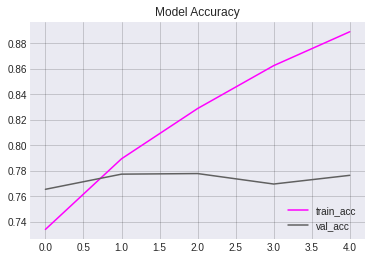

In [26]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(accuracies, color = 'magenta')
plt.plot(val_accuracies, color = '#606060')
plt.title('Model Accuracy')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

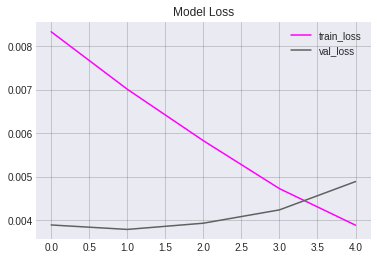

In [27]:
plt.figure()
plt.plot(losses, color = 'magenta')
plt.plot(val_losses, color = '#606060')
plt.title('Model Loss')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)